In [1]:
# TGS Machine Learning Notebook
# Created by Brandon Clary
# 8/15/2016

import os
import sys
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, erosion, dilation
from skimage.morphology import disk

import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Dropout, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import SGD
import keras.applications

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/core/indexes/bas

/home/kuantumlad/.local/lib/python2.7/site-packages/pywt/__init__.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._extensions._pywt import *
/home/kuantumlad/.local/lib/python2.7/site-packages/pywt/_swt.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._extensions._swt import swt_max_level, swt as _swt, swt_axis as _swt_axis
/home/kuantumlad/.local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/kuantumlad/.local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/kuantumlad/.local/lib/python2.7/site-packages/h5py/_hl/gr

In [2]:
# set path relative to current directory
os.path.join(os.path.curdir, 'input/')
ABS_INPUT_PATH = os.path.join(os.path.curdir, 'input/') #/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/'
TEST_PATH = 'test/'
TRAIN_PATH = 'train/'
MASKS_PATH = 'masks/'
IMAGES_PATH = 'images/'
DEPTH_PATH = ABS_INPUT_PATH + TRAIN_PATH + 'depths.csv'
IMAGE_PROPERTIES = (128,128,1)
ORIGINAL_IMG_PROPERTIES = (101,101,1)

In [3]:
def getTrainImageNames():
    path_to_train =  ABS_INPUT_PATH + TRAIN_PATH + IMAGES_PATH
    return sorted(next(os.walk(path_to_train))[2])

In [4]:
def getTrainMaskNames():
    return sorted(next(os.walk(ABS_INPUT_PATH + TRAIN_PATH + MASKS_PATH))[2])

In [5]:
def getTestImageNames():
    path_to_test =  ABS_INPUT_PATH + TEST_PATH + IMAGES_PATH
    return sorted(next(os.walk(path_to_test))[2])

# NO TEST MASKS EXISTS OBVIOUSLY :0
def getTestMaskNames():
    return sorted(next(os.walk(ABS_INPUT_PATH + TEST_PATH + MASKS_PATH))[2])

In [6]:
# depth is defined as "The value of the depth corresponds to the center of the image."
# The dictionary includes all images and all masks in the training set
def getImageDataDict():
    depth_of_images = {}
    with open(DEPTH_PATH, 'r') as f:
        x = f.read().splitlines()
        for line in x:
            image_name = line.split(',')[0]
            depth_to_center_of_image =  line.split(',')[1]
            depth_of_images[image_name] = depth_to_center_of_image
    return depth_of_images

In [7]:
def resizeImage(temp_image_array, new_dimensions):
    if( temp_image_array.shape == new_dimensions):
        return temp_image_array
    else:
        return resize(temp_image_array, new_dimensions, mode = 'constant', preserve_range=True)

In [8]:
def imageToArray(temp_image):
    return np.array(temp_image)[:,:,1]

def maskToArray(temp_mask):
    return np.array(temp_mask)

In [9]:
def getImage(temp_path_to_image):
    return cv2.imread(temp_path_to_image)

In [10]:
def downscale(input_image, resized_shape=(101,101,1)):
    height, width, channels = input_image.shape
    h_start = (height - resized_shape[0]) // 2
    w_start = (width - resized_shape[1]) // 2
    return input_image[h_start:resized_shape[0]+h_start, w_start:resized_shape[1]+w_start, :]


def upscale(input_image, resized_shape=(128,128,3)):
    new_image = np.zeros(shape=resized_shape)
    height = input_image.shape[0]
    width = input_image.shape[1]
    h_start = (resized_shape[0] - height) // 2
    w_start = (resized_shape[1] - width) // 2
    new_image[h_start:height+h_start, w_start:width+w_start] = input_image
    
    return new_image

In [11]:
#change 128x128 back to 101x101 later
#sys.stdout.flush()
def getTrainingData(x_train_path, y_train_path, img_type = '.png', RESIZE = (128,128,1), dim=1):
    print 'Splitting training data into numpy array for images and masks'
    n_training_entries = len(getTrainImageNames())
    X_train = np.zeros( (n_training_entries, RESIZE[0], RESIZE[1], dim), dtype = np.uint8 )
    Y_train = np.zeros( (n_training_entries, RESIZE[0], RESIZE[1], dim), dtype = np.bool )
    for i, x in enumerate(getTrainImageNames()):
        temp_x = resizeImage(getImage(x_train_path+x),(RESIZE[0],RESIZE[1],dim))
        temp_y = resizeImage(getImage(y_train_path+x),(RESIZE[0],RESIZE[1],dim))

        X_train[i] = temp_x#imageToArray(getImage(x_train_path+x)),RESIZE)
        Y_train[i] = temp_y#resizeImage(imageToArray(getImage(y_train_path+x)),RESIZE)
    print '>> DONE '
    return X_train, Y_train

In [58]:
def randomizeTrainingData(x_training,y_training,RESIZE=(101,101,1)):
    if len(x_training) != len(y_training):
        raise Exception("Length do not match")
    indices = range(len(x_training))
    np.random.shuffle(indices)

    n_training_entries = len(x_training)
    x_shuff = [x_training[i] for i in indices]
    y_shuff = [y_training[i] for i in indices]

    #x_shuff = np.zeros( (n_training_entries, RESIZE[0], RESIZE[1], RESIZE[2]), dtype = np.uint8 )
    #y_shuff = np.zeros( (n_training_entries, RESIZE[0], RESIZE[1], RESIZE[2]), dtype = np.bool )
    
    #for i in indices:
     #   x_shuff[i] = x_training[i]
     #   y_shuff[i] = y_training[i]
        
    
    return x_shuff, y_shuff

In [13]:
x_train_path = ABS_INPUT_PATH + TRAIN_PATH + IMAGES_PATH
y_train_path = ABS_INPUT_PATH + TRAIN_PATH + MASKS_PATH
#x_train_all, y_train_all = getTrainingData(x_train_path, y_train_path,RESIZE=(128,128,1))
#X_train, Y_train = randomizeTrainingData(x_train_all,y_train_all)

x_train_all, y_train_all = getTrainingData(x_train_path,y_train_path,RESIZE=(101,101,1))
x_train_orig, y_train_orig = randomizeTrainingData(x_train_all,y_train_all)

Splitting training data into numpy array for images and masks


/home/kuantumlad/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


>> DONE 


In [14]:
print x_train_all.shape

(4000, 101, 101, 1)


In [59]:
def checkTrainingData(x_data, y_data, img_to_check, n_rows = 4, n_col = 4):
    #write function to check the the formed training images and masks before sending to UNET
    f, axarr = plt.subplots(n_rows, n_col)
    f.set_size_inches((10,10))
    plot_factor = n_col/2
    x_shift = 2
    for i in range(n_rows):
        for j in range(plot_factor):
            get_random_img = np.random.randint(0,len(x_data))
            data = x_data[get_random_img]
            if i == 0:
                print data.shape
            temp_mask = y_data[get_random_img]
            #mask = np.squeeze(y_data[get_random_img]).astype(np.float32)

            #data = np.squeeze(data).astype(np.uint8)
            axarr[i,j*2].imshow(np.dstack((data,data,data)), cmap = 'gray')
            if img_to_check == "mask" or img_to_check == "both":
                mask = np.squeeze(temp_mask).astype(np.float32)
                axarr[i,2*j+1].imshow(np.dstack((mask,mask,mask)), cmap = 'gray')
            if img_to_check == "img":
                mask = temp_mask#np.squeeze(temp_mask).astype(np.uint8)
                axarr[i,2*j+1].imshow(np.dstack((mask,mask,mask)), cmap = 'gray')
                
            


(101, 101, 1)
(101, 101, 1)


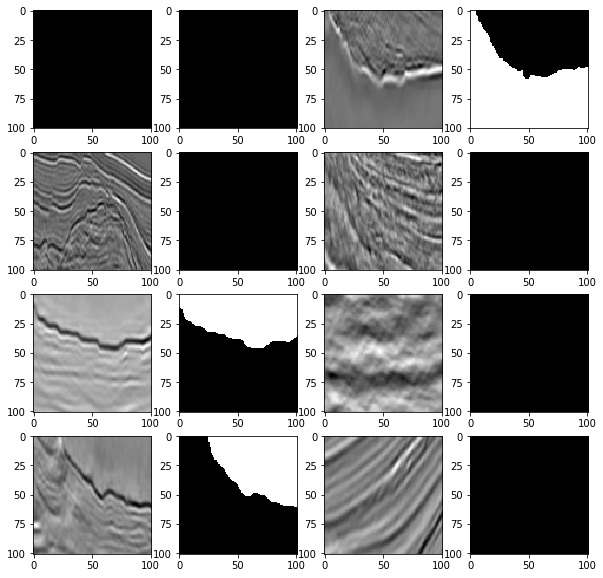

In [60]:
checkTrainingData(x_train_all,y_train_all, "both")

In [61]:
salt_fraction = []
for i in tnrange(len(y_train_orig)):

    image = y_train_orig[i]
    salt_present = 0
    image_area = ORIGINAL_IMG_PROPERTIES[0] * ORIGINAL_IMG_PROPERTIES[1]
    #print image.shape
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if image[row][col] == True:
                salt_present=salt_present+1
                    
    #print salt_present
    salt_percent = (salt_present / float(image_area))
    #print salt_percent
    salt_fraction.append(salt_percent)
print ">> DONE CALCULATE SALT PERCENTAGES PER IMAGE"


>> DONE CALCULATE SALT PERCENTAGES PER IMAGE


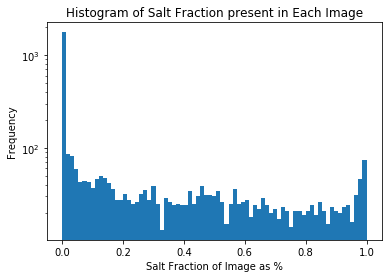

In [62]:
plt.hist(salt_fraction,75)
plt.title('Histogram of Salt Fraction present in Each Image')
plt.xlabel('Salt Fraction of Image as %')
plt.ylabel('Frequency')
plt.yscale('log')

In [63]:
def splitTraining(x_train, y_train, ratio_to_split):
    print 'Splitting Training set into a train and validation set'
    if ratio_to_split > 1.0 or ratio_to_split < 0.0:
        raise Exception("Specify split value between 0.0 and 1.0")
    
    train_lim = int(math.floor((1-ratio_to_split) * len(x_train)))
    x_train_split = x_train[:train_lim]
    y_train_split = y_train[:train_lim]
    
    x_val_split = x_train[train_lim:]
    y_val_split = y_train[train_lim:]
    
    if ratio_to_split == 1.0:
        x_train_split = x_train
        y_train_split = y_train
        
    return x_train_split, y_train_split, x_val_split, y_val_split
    
#x_train_split, y_train_split, x_val, y_val = splitTraining(X_train,Y_train,1.0)

In [64]:
def augmentDataRotation(x_train, y_train, axis_to_rotate = 0):
    print 'Augmenting Data via Spatial Rotation'
    #x_test = np.flip(x_train, axis_to_rotate)
    x_aug = np.copy(x_train)
    y_aug = np.copy(y_train)
    for i in range(len(x_train)):
        x_aug[i] = np.flip(x_train[i],axis_to_rotate)
        y_aug[i] = np.flip(y_train[i],axis_to_rotate)        
    
    #f, axarr = plt.subplots(1,2)
    #axarr[0].imshow(np.dstack((x_test,x_test,x_test)))
    #axarr[1].imshow(np.dstack((x_og,x_og,x_og)))
    return x_aug, y_aug

In [18]:
def salt_pepper(original_image):
    row = original_image.shape[0]
    col = original_image.shape[1]
    
    #print row
    #print col
    for i in range(row):
        for j in range(col):            
            pix = original_image[i,j]            
            alter = np.random.randint(10)
            
            if alter < 2:
                    #continue
                original_image[i,j] = pix
            if alter == 1:                        
                set_salt_pepper = np.random.randint(2)                        
                if set_salt_pepper == 1:
                    original_image[i,j] = [255]
                if set_salt_pepper == 0:
                    original_image[i,j] = [0]
            #print original_image[i,j]
    sp_image = original_image
    return sp_image

In [65]:
print 'Augment data to increase number of training instances'
X_aug_train, Y_aug_train = augmentDataRotation(x_train_orig, y_train_orig, 1)
#print X_aug_train.shape
#[salt_pepper(img) for img in X_aug_train] #inline function to salt&pepper the data with noise
#[salt_pepper(img) for img in x_train_orig]

Augment data to increase number of training instances
Augmenting Data via Spatial Rotation


[[153 150 147 ... 165 165 165]
 [152 149 146 ... 165 165 165]
 [152 149 147 ... 163 163 163]
 ...
 [179 178 177 ... 177 182 183]
 [165 165 165 ... 162 161 157]
 [151 152 153 ... 146 139 130]]


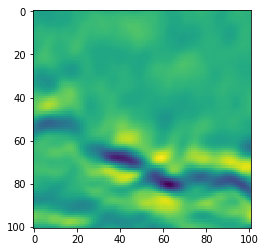

In [66]:
f, axarr = plt.subplots(1,1)
temp_img = np.squeeze(X_aug_train[6]).astype(np.uint8)
print temp_img
axarr.imshow(temp_img)#np.dstack((temp_img,temp_img,temp_img)), cmap = 'gray')

(4000, 101, 101, 1)
(4000, 101, 101, 1)
(101, 101, 1)
(101, 101, 1)
Done


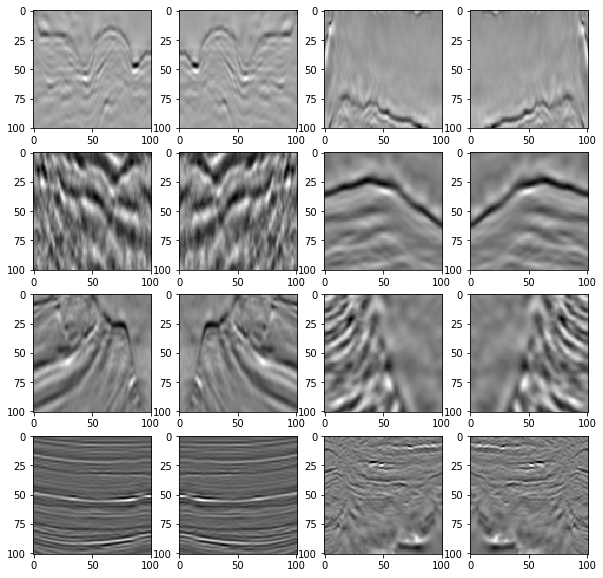

In [67]:
print X_aug_train.shape
print x_train_all.shape
checkTrainingData(x_train_orig, X_aug_train, "img")
print 'Done'

In [68]:
def addAugmentedData(x_train, x_aug_to_add, y_train, y_aug_to_add):
    x_new = np.concatenate((x_train,x_aug_to_add))
    y_new = np.concatenate((y_train,y_aug_to_add))
    return x_new, y_new

In [69]:
#X_train, Y_train = randomizeTrainingData(x_train_all,y_train_all)
X_train_enhanced, Y_train_enhanced = addAugmentedData(x_train_orig, X_aug_train, y_train_orig, Y_aug_train)
#print 'Concatenated the augmented data to the original data - total training size is now'
X_train_rand, Y_train_rand = randomizeTrainingData(X_train_enhanced,Y_train_enhanced)
print 'done'

done


In [70]:
X_train_upscale = np.zeros((len(X_train_rand),128,128,1))
Y_train_upscale = np.zeros((len(Y_train_rand),128,128,1))
for i, img in enumerate(X_train_rand):
    X_train_upscale[i] = ( upscale(img, (128,128,1)) )
for i, img in enumerate(Y_train_rand):
    Y_train_upscale[i] = ( upscale(img, (128,128,1)) )

print "done"

done


In [71]:
def checkOutputResults(train, mask, temppred, n_rows = 4, n_cols = 3):
    f, axarr = plt.subplots(n_rows, n_cols)
    f.set_size_inches((10,10))
    for i in range(n_rows):
        get_random_img = np.random.randint(0,len(train))
        data = train[get_random_img]
        true = mask[get_random_img]
        pred = temppred[get_random_img]
               
        # plotting pred[:,:,0] will make a 2d plot showing probability assigned to each pixel by the model
        # each pixel is assigned a value between 0 to 1.
        axarr[i,0].imshow(np.dstack((data,data,data)))
        true_plt = np.squeeze(true).astype(np.float32)
        axarr[i,1].imshow(np.dstack((true_plt,true_plt,true_plt)), cmap = 'viridis',interpolation='none')
        pred_ax = axarr[i,2].imshow(pred[:,:,0], cmap = 'viridis',interpolation='none')
        plt.colorbar(pred_ax, ax=axarr[i,2])
        plt.show

In [72]:
# Now it is time to build the CNN model.
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

sys.stdout.flush()

(8000, 128, 128, 1)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


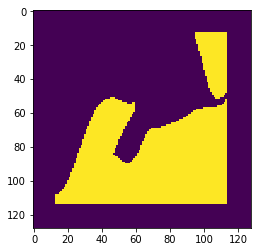

In [74]:
print Y_train_upscale.shape
f, axarr = plt.subplots(1,1)
temp_img = np.squeeze(Y_train_upscale[80]).astype(np.uint8)
print temp_img
axarr.imshow(temp_img)#np.dstack((temp_img,temp_img,temp_img)), cmap = 'gray')

In [79]:
def create_model( n_filters = 4, opt='adam', temp_loss='binary_crossentropy', temp_metrics=[mean_iou], inputs = IMAGE_PROPERTIES, load_pretrain_model = False ):
    inputs = Input(IMAGE_PROPERTIES)
    s = Lambda(lambda x: x / 255) (inputs)
    
    #d0 = Conv2D(n_filters*1, (3,3), padding='same') (s)
    #d0 = Conv2D(n_filters*1, (3,3), activation='elu', padding='same')(d0)
    #dbn0 = BatchNormalization()(d0)
    #d0 = Conv2D(n_filters*1, (3,3), padding='same')(dbn0)
    #d0 = Conv2D(n_filters, (3,3), activation='elu',padding='same')(d0)
    #dp0 = MaxPooling2D((2, 2)) (d0)
    
    d1 = Conv2D(n_filters*2, (3,3), activation='elu', padding='same') (s)
    d1 = Conv2D(n_filters*2, (3,3), activation='elu', padding='same')(d1)
    dbn1 = BatchNormalization()(d1)
    #d1 = Conv2D(n_filters*2, (3,3), activation='elu', padding='same')(dbn1)
    #d1 = Conv2D(n_filters*2, (3,3), activation='elu', padding='same')(d1)
    dp1 = MaxPooling2D((2, 2)) (d1)
    
    d2 = Conv2D(n_filters*4, (3,3), activation='elu', padding='same') (dp1)
    d2 = Conv2D(n_filters*4, (3,3), activation='elu', padding='same')(d2)
    dbn2 = BatchNormalization()(d2)
    #d2 = Conv2D(n_filters*4, (3,3), activation='elu', padding='same')(dbn2)
    #d2 = Conv2D(n_filters*4, (3,3), activation='elu',padding='same')(d2)
    dp2 = MaxPooling2D((2, 2)) (d2)
    sdo2 = SpatialDropout2D(0.25)(dp2)

    d3 = Conv2D(n_filters*8, (3,3), activation='elu',padding='same') (sdo2)#dp2)
    d3 = Conv2D(n_filters*8, (3,3), activation='elu', padding='same')(d3)
    dbn3 = BatchNormalization()(d3)
    #d3 = Conv2D(n_filters*8, (3,3), activation='elu',padding='same')(dbn3)
    #d3 = Conv2D(n_filters*8, (3,3), activation='elu',padding='same')(d3)
    dp3 = MaxPooling2D((2, 2)) (d3)
    sdo3 = SpatialDropout2D(0.25)(dp3)

    d4 = Conv2D(n_filters*16, (3,3), activation='elu',padding='same') (sdo3)
    d4 = Conv2D(n_filters*16, (3,3), activation='elu', padding='same')(d4)
    dbn4 = BatchNormalization()(d4)
    #d4 = Conv2D(n_filters*16, (3,3), activation='elu',padding='same')(dbn4)
    #d4 = Conv2D(n_filters*16, (3,3), activation='elu',padding='same')(d4)
    dp4 = MaxPooling2D((2, 2)) (d4)
    sdo4 = SpatialDropout2D(0.25)(dp4)
     
    d5 = Conv2D(n_filters*32, (3,3), activation='elu',padding='same') (sdo4)
    d5 = Conv2D(n_filters*32, (3,3), activation='elu', padding='same')(d5)
    dbn5 = BatchNormalization()(d5)
    #d5 = Conv2D(n_filters*32, (3,3), activation='elu',padding='same')(dbn5)
    #d5 = Conv2D(n_filters*32, (3,3), activation='elu',padding='same')(d5)
    dp5 = MaxPooling2D((2, 2)) (d5) 
    sdo5 = SpatialDropout2D(0.25)(dp5)
    
    # bottom of u-net
    mc6 = Conv2D(128, (3,3), activation='elu',padding='same') (sdo5)
    mc6 = Conv2D(128, (3,3), activation='elu', padding='same')(mc6)
    #mbn6 = BatchNormalization()(mc6)
    #m6 = Conv2D(128, (3,3), activation='elu',padding='same')(mbn6)
    #m6 = Conv2D(128, (3,3), activation='elu',padding='same')(m6)

    #if (load_pretrain_model) :
     #   x = Flatten(name='flatten')(x)
     #   x = Dense(4096, activation='relu', name='fc1')(x)
     #   x = Dense(4096, activation='relu', name='fc2')(x)
     #   x = Dense( 1024 , activation='softmax', name='predictions')(x)

    #vgg  = Model(  inputs , m6 )
    #vgg.load_weights(VGG_Weights_path)
        
    
    cu5 = Conv2DTranspose(n_filters*32, (2, 2), strides=(2, 2), padding='same') (mc6)
    cu5 = concatenate([cu5, d5])
    usdo5 = SpatialDropout2D(0.25)(cu5)
    u5 = Conv2D(n_filters*32, (3,3), activation='elu', padding='same')(usdo5)#cu5)
    u5 = Conv2D(n_filters*32, (3,3), activation='elu',padding='same')(u5)
    #u5 = Conv2D(n_filters*32, (3,3), activation='elu', padding='same')(u5)
    #u5 = Conv2D(n_filters*32, (3,3), activation='elu',padding='same')(u5)
    #SpatialDropout2D(0.5)
    
    cu4 = Conv2DTranspose(n_filters*16, (2, 2), strides=(2, 2), padding='same') (u5)
    cu4 = concatenate([cu4, d4])
    usdo4 = SpatialDropout2D(0.25)(cu4)
    u4 = Conv2D(n_filters*16, (3,3), activation='elu', padding='same')(usdo4)#cu4)
    u4 = Conv2D(n_filters*16, (3,3), activation='elu',padding='same')(u4)
    #u4 = Conv2D(n_filters*16, (3,3), activation='elu', padding='same')(u4)
    #u4 = Conv2D(n_filters*16, (3,3), activation='elu',padding='same')(u4)
    
    cu3 = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same') (u4)
    cu3 = concatenate([cu3, d3])
    usdo3 = SpatialDropout2D(0.25)(cu3)
    u3 = Conv2D(n_filters*8, (3,3), activation='elu', padding='same')(usdo3)
    u3 = Conv2D(n_filters*8, (3,3), activation='elu',padding='same')(u3)
    #u3 = Conv2D(n_filters*8, (3,3), activation='elu', padding='same')(u3)
    #u3 = Conv2D(n_filters*8, (3,3), activation='elu',padding='same')(u3)
    
    cu2 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same') (u3)
    cu2 = concatenate([cu2, d2])
    usdo2 = SpatialDropout2D(0.25)(cu2)
    u2 = Conv2D(n_filters*4, (3,3), activation='elu', padding='same')(usdo2)
    u2 = Conv2D(n_filters*4, (3,3), activation='elu',padding='same')(u2)
    #u2 = Conv2D(n_filters*4, (3,3), activation='elu', padding='same')(u2)
    #u2 = Conv2D(n_filters*4, (3,3), activation='elu',padding='same')(u2)
    
    cu1 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same') (u2)
    cu1 = concatenate([cu1, d1])
    u1 = Conv2D(n_filters*2, (3,3), activation='elu', padding='same')(cu1)
    u1 = Conv2D(n_filters*2, (3,3), activation='elu',padding='same')(u1)
    #u1 = Conv2D(n_filters*2, (3,3), activation='elu', padding='same')(u1)
    #u1 = Conv2D(n_filters*2, (3,3), activation='elu',padding='same')(u1)
    
    #cu0 = Conv2DTranspose(2, (2, 2), strides=(2, 2), padding='same') (u1)
    #cu0 = concatenate([cu0, c0], axis=3)
    #u0 = Conv2D(2, (3,3), activation='elu', padding='same')(u12)
    #u0 = Conv2D(2, (3,3), padding='same')(c12)
    #u0 = Conv2D(2, (3,3), activation='elu', padding='same')(c12)
    #u0 = Conv2D(2, (3,3), padding='same')(c12)
    #Dropout(0.05)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=opt, loss=temp_loss, metrics=[temp_metrics])
    model.summary()
    return model

In [38]:
#inputs = Input(IMAGE_PROPERTIES)
#s = Lambda(lambda x: x / 255) (inputs)

#c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
#c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
#p1 = MaxPooling2D((2, 2)) (c1)
#p1 = AveragePooling2D((2,2))(c1)

#c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
#c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
#p2 = MaxPooling2D((2, 2)) (c2)

#c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
#c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
#p3 = MaxPooling2D((2, 2)) (c3)

#c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
#c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
#p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

#c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
#c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

#u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#u6 = concatenate([u6, c4])
#c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
#c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

#u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
#u7 = concatenate([u7, c3])
#c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
#c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

#u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
#u8 = concatenate([u8, c2])
#c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
#c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

#u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
#u9 = concatenate([u9, c1], axis=3)
#c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
#c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

#outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

#model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.summary()

In [81]:
sgd = SGD(lr=0.001, momentum=0.7, decay=1e-6, nesterov=True)
model = create_model(6, sgd, 'binary_crossentropy', 'accuracy', IMAGE_PROPERTIES)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 128, 128, 12) 120         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 128, 128, 12) 1308        conv2d_43[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [82]:
def fit_model( model ):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
    results = model.fit(X_train_upscale, Y_train_upscale, validation_split=0.2, batch_size=8, epochs=200, 
                    callbacks=[earlystopper, checkpointer])
    #plt.plot(results.history['loss'])
    #plt.plot(results.history['val_loss'])
    #plt.xlabel('Epoch')
    return results

In [ ]:
my_fit_results = fit_model(model)

Train on 6400 samples, validate on 1600 samples
Epoch 1/200
6400/6400 [==============================] - 81s 13ms/step - loss: 0.4813 - acc: 0.8371 - val_loss: 0.4166 - val_acc: 0.8386

Epoch 00001: val_loss improved from inf to 0.41660, saving model to model-tgs-salt-1.h5
Epoch 2/200
6400/6400 [==============================] - 79s 12ms/step - loss: 0.3882 - acc: 0.8471 - val_loss: 0.3929 - val_acc: 0.8379

Epoch 00002: val_loss improved from 0.41660 to 0.39292, saving model to model-tgs-salt-1.h5
Epoch 3/200
6400/6400 [==============================] - 79s 12ms/step - loss: 0.3771 - acc: 0.8471 - val_loss: 0.3816 - val_acc: 0.8386

Epoch 00003: val_loss improved from 0.39292 to 0.38157, saving model to model-tgs-salt-1.h5
Epoch 4/200
6400/6400 [==============================] - 79s 12ms/step - loss: 0.3655 - acc: 0.8474 - val_loss: 0.3703 - val_acc: 0.8386

Epoch 00004: val_loss improved from 0.38157 to 0.37034, saving model to model-tgs-salt-1.h5
Epoch 5/200
6400/6400 [=============

In [125]:
#earlystopper = EarlyStopping(patience=4, verbose=1)
#checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train_enhanced, Y_train_enhanced, validation_split=0.2, batch_size=8, epochs=50, 
 #                   callbacks=[earlystopper, checkpointer])

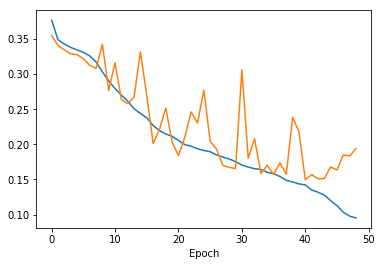

In [128]:
plt.plot(my_fit_results.history['loss'])
plt.plot(my_fit_results.history['val_loss'])
plt.xlabel('Epoch')
plt.savefig('loss_v2c.png')

In [21]:
def getTestingData(x_test_path, img_type = '.png', RESIZE = (101,101,1)):
    n_testing_entries = len(getTestImageNames())
    X_test = np.zeros( (n_testing_entries, RESIZE[0], RESIZE[1], RESIZE[2]), dtype = np.uint8 )
    x_shape = []
    for i, x in enumerate(getTestImageNames()):
        X_test[i] = resizeImage(imageToArray(getImage(x_test_path+x)),RESIZE)
        x_shape.append([imageToArray(getImage(x_test_path+x)).shape[0], imageToArray(getImage(x_test_path+x)).shape[1]])
    print '>> DONE '
    return X_test, x_shape

In [22]:
x_test_path = ABS_INPUT_PATH + TEST_PATH + IMAGES_PATH
print(" GETTING DATA FROM " + x_test_path)
X_test, sizes_test = getTestingData(x_test_path)
print X_test.shape

 GETTING DATA FROM ./input/test/images/
>> DONE 
(18000, 101, 101, 1)


In [23]:
X_train_split, Y_train_split, X_val, Y_val = splitTraining(x_train_all, y_train_all,0.2)
print len(X_train_split)
print len(X_val)
print X_train_split[0].shape
X_train_split_upscale = np.zeros((len(X_train_split),128,128,1))
Y_train_split_upscale = np.zeros((len(Y_train_split),128,128,1))
for i, img in enumerate(X_train_split):
    X_train_split_upscale[i] = ( upscale(img, (128,128,1)) )

    
X_val_upscale = np.zeros((len(X_val),128,128,1))

for i, img in enumerate(X_val):
    X_val_upscale[i] = ( upscale(img, (128,128,1)) )
    
print X_train_split_upscale[0].shape
print X_val_upscale[0].shape


X_test_upscale = np.zeros((len(X_test),128,128,1))

for i, img in enumerate(X_test):
    X_test_upscale[i] = ( upscale(img, (128,128,1)) )

print X_test_upscale[0].shape

Splitting Training set into a train and validation set
3200
800
(101, 101, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


In [26]:
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train_split_upscale, verbose=1)
preds_val = model.predict(X_val_upscale, verbose=1)
preds_test_train = model.predict(X_train_split_upscale, verbose=1)
pred_test = model.predict(X_test_upscale, verbose=1)

18000/18000 [==============================] - 90s 5ms/step


In [401]:
# test gray scale dilation 
def dilateImage(original_image, search_dim=1):
    row = original_image.shape[0]
    col = original_image.shape[1]
    
    #print row
    #print col
    dil_image = original_image
    for i in range(row): #change to while loop for -1 to 1
        for j in range(col):            
            pix = original_image[i,j]    
            temp_max = 0.0
            current_max = pix
            for s_x in range(search_dim):
                for s_y in range(search_dim):
                    if temp_max > pix:
                        current_max = pix
            dil_image[i,j] = [current_max]

    return dil_image

[ dilateImage(x) for x in preds_test_train ]
print "DONE WITH DILATION OF TEST DATA"

DONE WITH DILATION OF TEST DATA


In [407]:
# adding erosion filter to post processing.
# dilation followed by erosion files in gaps within images
def erodeImage(original_image, search_dim=1):
    row = original_image.shape[0]
    col = original_image.shape[1]
    
    #print row
    #print col
    out_image = original_image
    for i in range(row):
        for j in range(col):            
            pix = original_image[i,j]    
            temp_max = 0.0
            current_max = pix
            for s_x in range(search_dim):
                for s_y in range(search_dim):
                    if temp_max < pix:
                        current_max = pix
            out_image[i,j] = [current_max]

    return out_image

[ erodeImage(x) for x in preds_test_train ]
print "DONE WITH EROSION OF TEST DATA"

DONE WITH EROSION OF TEST DATA


In [76]:
def filterGaus(temp_image):
    return cv2.GaussianBlur(temp_image,(7,7),0)

[ filterGaus(x) for x in preds_test_train ]

[array([[0.02135137, 0.01844957, 0.0129753 , ..., 0.01844434, 0.02929853,
         0.0348718 ],
        [0.01779394, 0.01532782, 0.01068462, ..., 0.01548824, 0.02482258,
         0.02962999],
        [0.01075963, 0.00918532, 0.00623856, ..., 0.00964026, 0.01584365,
         0.01906655],
        ...,
        [0.00425903, 0.00347465, 0.00203076, ..., 0.0046765 , 0.0081306 ,
         0.00991476],
        [0.00627083, 0.00516103, 0.00310163, ..., 0.00727181, 0.01233372,
         0.0148964 ],
        [0.00726886, 0.00600287, 0.00364616, ..., 0.00866495, 0.01457461,
         0.01754469]], dtype=float32),
 array([[0.01984576, 0.01712501, 0.01198352, ..., 0.0191071 , 0.03029858,
         0.03604662],
        [0.01649535, 0.01419079, 0.00984458, ..., 0.01606833, 0.02571302,
         0.03068192],
        [0.00989545, 0.00843906, 0.00570874, ..., 0.01004873, 0.01650046,
         0.01985405],
        ...,
        [0.00451915, 0.00368954, 0.00216237, ..., 0.00459285, 0.00797823,
         0.00972698

3200
4000
(3200, 128, 128, 1)
(4000, 101, 101, 1)


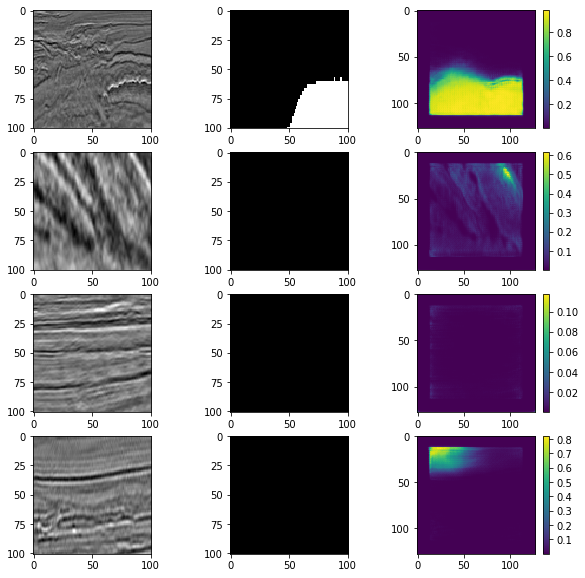

In [46]:
print len(preds_train)
print len(y_train_all)
print preds_train.shape
print x_train_all.shape
#checkTrainingData(preds_test,y_train_all,"img")

checkOutputResults(X_train_split,Y_train_split,preds_test_train)

[array([[0.03152455, 0.02492286, 0.01416712, ..., 0.01864843, 0.03951674,
         0.05195754],
        [0.0238518 , 0.01869669, 0.0103309 , ..., 0.01400395, 0.03060876,
         0.04056376],
        [0.01069294, 0.00811555, 0.00399022, ..., 0.00616266, 0.01507753,
         0.02051917],
        ...,
        [0.00476511, 0.00338738, 0.00122858, ..., 0.00280137, 0.00758993,
         0.01052341],
        [0.00865322, 0.00632478, 0.00261929, ..., 0.00644086, 0.01522985,
         0.02038365],
        [0.01088038, 0.00802612, 0.00345865, ..., 0.00874173, 0.01997775,
         0.02647647]], dtype=float32),
 array([[0.02940489, 0.0232203 , 0.01312262, ..., 0.01930456, 0.040767  ,
         0.05356616],
        [0.02215209, 0.01734563, 0.00953034, ..., 0.01452944, 0.03166967,
         0.04194982],
        [0.00976458, 0.00740354, 0.00361947, ..., 0.00645378, 0.01577455,
         0.02146696],
        ...,
        [0.00505892, 0.00359987, 0.00131314, ..., 0.00274829, 0.00743445,
         0.01030504

In [47]:
preds_train_t = (preds_train > 0.6).astype(np.uint8)
preds_val_t = (preds_val > 0.6).astype(np.uint8)
preds_test_t = (pred_test > 0.6).astype(np.uint8)

In [48]:
print preds_test_t.shape
print pred_test.shape
#print pred_test[0]
pred_test_downscale = np.zeros((len(preds_test_t),101,101,1))

for i, img in enumerate(preds_test_t):
    pred_test_downscale[i] = ( downscale(img, (101,101,1)) )

print pred_test_downscale[0].shape

(18000, 128, 128, 1)
(18000, 128, 128, 1)
(101, 101, 1)


In [49]:
preds_test_upsampled = []
for i in tnrange(len(pred_test_downscale)):
    preds_test_upsampled.append(resize(np.squeeze(pred_test_downscale[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

(101, 101)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 0]]


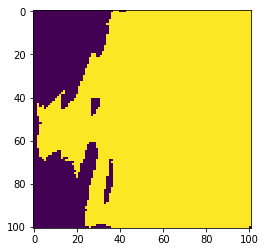

In [50]:
# Test shape
print preds_test_upsampled[0].shape
print preds_test_upsampled[30]

f, axarr = plt.subplots(1,1)
temp_img = np.squeeze(preds_test_upsampled[5]).astype(np.uint8)
print temp_img
axarr.imshow(temp_img)

In [51]:
# Lets look at the predicted salt fraction covered in the images and plot it then overlay it.
# it should follow the parent distribution!
pred_salt_fraction = []
for i in tnrange(len(preds_test_upsampled)):

    image = preds_test_upsampled[i]
    salt_present = 0
    image_area = ORIGINAL_IMG_PROPERTIES[0] * ORIGINAL_IMG_PROPERTIES[1]
    #print image.shape
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if image[row][col] == True:
                salt_present=salt_present+1
                    
    #print salt_present
    salt_percent = (salt_present / float(image_area))
    #print salt_percent
    pred_salt_fraction.append(salt_percent)
print ">> DONE CALCULATE SALT PERCENTAGES PER IMAGE"


>> DONE CALCULATE SALT PERCENTAGES PER IMAGE


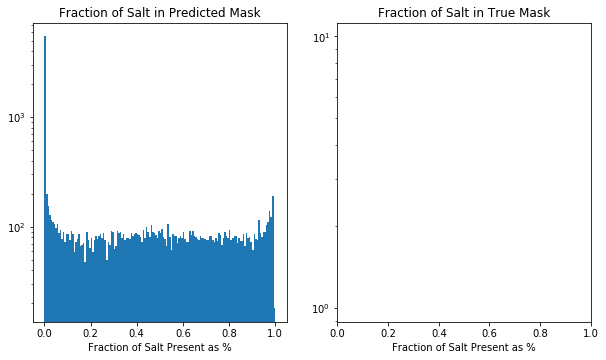

In [53]:
#plt.hist(pred_salt_fraction,250)
#plt.yscale('log')
fig, ax = plt.subplots(1,2)
fig.set_size_inches((10,5.5))
ax[0].hist(pred_salt_fraction,150)
ax[0].set_title('Fraction of Salt in Predicted Mask')
ax[0].set_yscale('log')
ax[0].set_xlabel('Fraction of Salt Present as %')
#ax[1].hist(salt_fraction,75)
ax[1].set_title('Fraction of Salt in True Mask')
ax[1].set_yscale('log')
ax[1].set_xlabel('Fraction of Salt Present as %')
fig.savefig('salt_fraction_v2c.png')

In [54]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

    
test_ids = next(os.walk(ABS_INPUT_PATH + TEST_PATH + IMAGES_PATH))[2]
print len(test_ids)
print len(preds_test_upsampled)
pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(getTestImageNames()))}

18000
18000


In [55]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_v2c_arch_noaug_nf6.csv')